In [57]:
import sys
import json
import nltk
import re
from collections import Counter
import string
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from nltk import bigrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from tqdm.notebook import tqdm
import numpy as np
import math
import statistics
from nltk.corpus import words
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sppag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sppag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\sppag\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sppag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sppag\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\sppag\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corp

True

In [109]:
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
yt_data =pd.read_csv("t20_youtube_comments_filtered.csv")

In [3]:
yt_data.shape

(69247, 8)

In [4]:
yt_data.head()

,video_id,video_title,video_published_at,comment_id,author,published_at,like_count,text
0,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01T00:03:10Z,UgzEN6KIn3XOG3vyDkp4AaABAg,@Griffinatus,2024-07-01T01:58:37Z,9300,The innings by kohli.\nThe innings by axar.\nT...
1,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01T00:03:10Z,UgzEFVkhnorEOn6Jhbh4AaABAg,@_Joyboy1,2024-07-01T00:41:02Z,3115,Happy retirement ROKO and sir jadeja🧎💐
2,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01T00:03:10Z,UgwV1P6xqTATKEqD9v94AaABAg,@Champ_Akash,2024-07-01T00:05:50Z,2611,Happy retirement ROKO from T20I ❤❤\nAnd we can...
3,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01T00:03:10Z,UgyKudsaT_Rm_L_O4RN4AaABAg,@farellesmanff6072,2024-07-01T02:08:33Z,1211,*Nothing more satisfying than hearing a crowd ...
4,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01T00:03:10Z,UgzJZCKBR4ItiNrDD154AaABAg,@diptiborthakurdas3275,2024-07-01T08:13:16Z,781,'Mummy ka magic' worked🥺🥺


In [5]:
yt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69247 entries, 0 to 69246
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   video_id            69247 non-null  object
 1   video_title         69247 non-null  object
 2   video_published_at  69247 non-null  object
 3   comment_id          69247 non-null  object
 4   author              69246 non-null  object
 5   published_at        69247 non-null  object
 6   like_count          69247 non-null  int64 
 7   text                69242 non-null  object
dtypes: int64(1), object(7)
memory usage: 4.2+ MB


In [6]:
yt_data['video_published_at'] = pd.to_datetime(yt_data['video_published_at'])
yt_data['published_at'] = pd.to_datetime(yt_data['published_at'])

In [7]:
yt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69247 entries, 0 to 69246
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   video_id            69247 non-null  object             
 1   video_title         69247 non-null  object             
 2   video_published_at  69247 non-null  datetime64[ns, UTC]
 3   comment_id          69247 non-null  object             
 4   author              69246 non-null  object             
 5   published_at        69247 non-null  datetime64[ns, UTC]
 6   like_count          69247 non-null  int64              
 7   text                69242 non-null  object             
dtypes: datetime64[ns, UTC](2), int64(1), object(5)
memory usage: 4.2+ MB


In [8]:
yt_data.isna().sum()

video_id              0
video_title           0
video_published_at    0
comment_id            0
author                1
published_at          0
like_count            0
text                  5
dtype: int64

In [9]:
yt_data = yt_data.dropna()
yt_data.isna().sum()

video_id              0
video_title           0
video_published_at    0
comment_id            0
author                0
published_at          0
like_count            0
text                  0
dtype: int64

In [10]:
# oldest and newest comment dates
oldest = yt_data['published_at'].min()
newest = yt_data['published_at'].max()

print(f"Oldest : {oldest}")
print(f"Newest : {newest}")

Oldest : 2023-12-07 07:07:53+00:00
Newest : 2024-10-09 22:00:16+00:00


In [11]:
# no of unique authors
yt_data['author'].nunique()

50508

In [12]:
# possible bots as authors
contains_bot = yt_data['author'].str.lower().str.contains('bot')
authors_with_bot = yt_data[contains_bot]
possible_bots = authors_with_bot['author'].unique()
possible_bots

array(['@ROBOTERGAMER-ix8cf', '@bothardgaming9000', '@bluebottle548',
       '@BOTYTgaming', '@steveskrobot9496', '@sahiljambotkar-xr5nl',
       '@ZoeBottrill', '@abbotonian', '@bothside-gamer8425',
       '@botedngaming4560', '@DK_SK_BOT4', '@manavbothra1671',
       '@ROBOTVEDYT', '@RockBottomofficial067', '@HamzaNawazBotanist',
       '@bots2614', '@Roboto727', '@psychobot8743', '@SlayBotYT',
       '@botgirlgaming2223', '@BottomBladder', '@kumarnallabothula2844',
       '@Unexpected_Bot', '@MaximBot-z', '@agrobot3063', '@MasakoKubota',
       '@Nightbot_1337', '@BotaFreefirepro123', '@manobotar-pokkhe',
       '@Aimbot999-e4g', '@jotshnabotsa9306', '@t10teambotlike67',
       '@cluchbot6509', '@Anthonybot', '@Bottlemen7', '@faiyazmrrobot126',
       '@gameofbot01'], dtype=object)

In [13]:
# comments by possible bots
bot_comments = yt_data[yt_data['author'].isin(possible_bots)]
bot_comments.shape

(52, 8)

In [14]:
# since no of comments is 52/69247, decided to keep the comments since it is not obvious to decide these are bots.

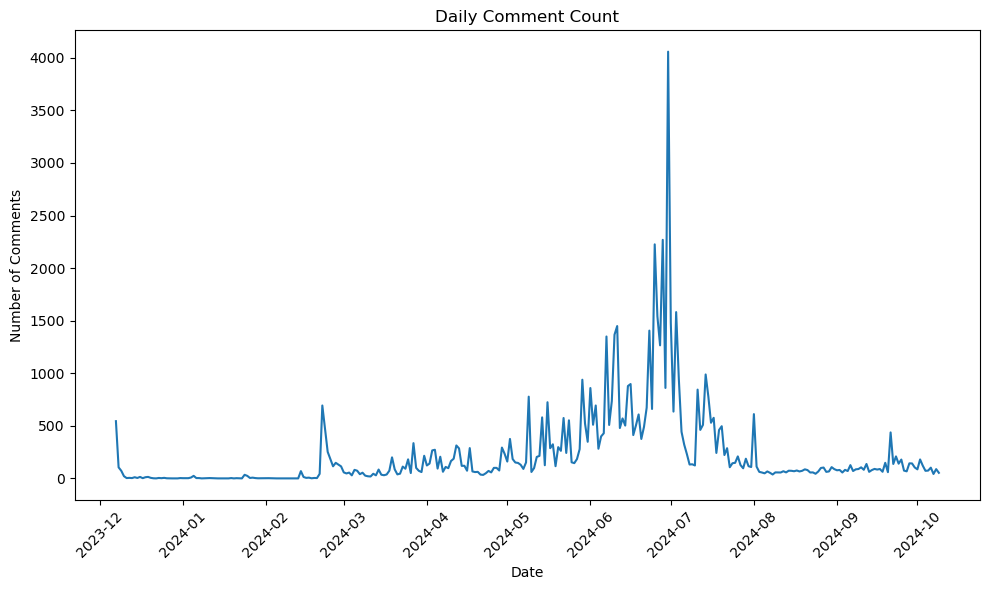

In [15]:
# comments in each day

grouped_by_date = yt_data.groupby(yt_data['published_at'].dt.date).size()

# creating plot
plt.figure(figsize=(10,6))
grouped_by_date.plot(kind='line')
plt.title('Daily Comment Count')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# t20 worldcup 2nd June 2024 - 30 June 24

In [17]:
# median comments per day
grouped_by_date.median()

90.0

In [18]:
# 90 comments a day is the median for t20

In [19]:
# days with more than 1000 comments
grouped_by_date[grouped_by_date > 1000]

published_at
2024-06-07    1350
2024-06-10    1367
2024-06-11    1449
2024-06-23    1406
2024-06-25    2226
2024-06-26    1542
2024-06-27    1266
2024-06-28    2269
2024-06-30    4058
2024-07-01    1481
2024-07-03    1582
dtype: int64

In [20]:
# all the days are during T20 final period

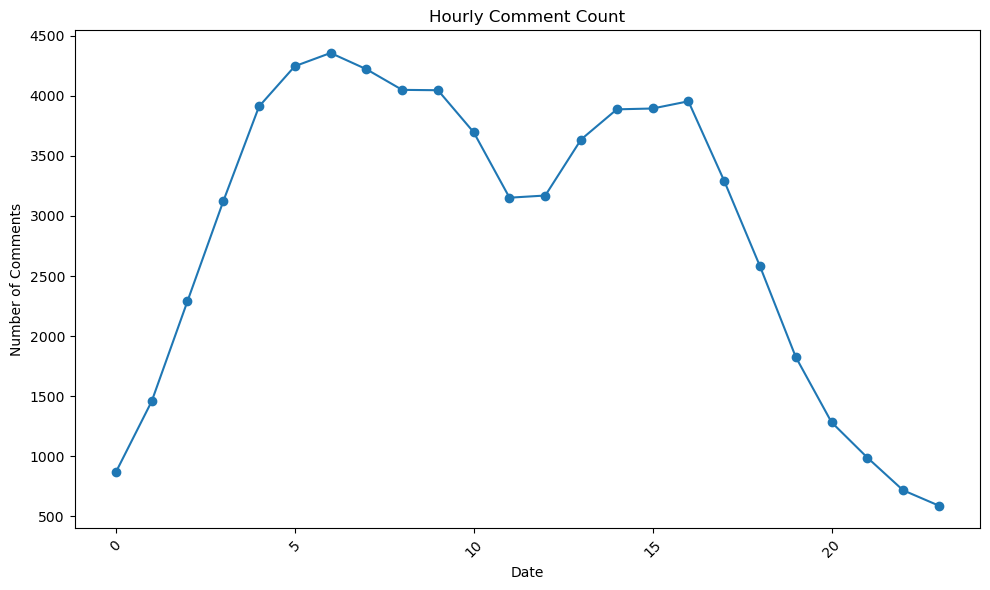

In [21]:
# comments by hour
grouped_by_hour = yt_data.groupby(yt_data['published_at'].dt.hour).size()

# creating plot
plt.figure(figsize=(10,6))
grouped_by_hour.plot(kind='line',marker='o')
plt.title('Hourly Comment Count')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# sorted by comment-like count
yt_data_sorted = yt_data.sort_values(by='like_count', ascending=False).head(n=50)
yt_data_sorted

,video_id,video_title,video_published_at,comment_id,author,published_at,like_count,text
67821,xKMRx_upkRY,Who is faster than Jofra Archer? 😮‍💨#T20WorldC...,2024-06-05 13:15:04+00:00,UgyKKhUvaw_jCsfBhYJ4AaABAg,@Ifnotyouthenwho._.,2024-06-06 07:34:48+00:00,20079,Jofra voice 🧒🏻\nJofra bowling 💀
25597,OSTMKBLDoLg,The American fairytale continues as USA beat P...,2024-06-06 23:37:36+00:00,UgxkuYq-k0GPZj6E3Eh4AaABAg,@sanamir160,2024-06-06 23:54:46+00:00,16860,Pakistan qualified for Karachi auto stand 😂😂😂😂
33900,V8m8equTo3c,Ric Flair 🤝 Rohit Sharma #T20WorldCup #Cricket...,2024-06-30 02:46:48+00:00,Ugy1ZIz238QhGtknpjx4AaABAg,@sudipta.mondal.6899,2024-06-30 02:47:44+00:00,12583,Indian fans show true emotions ❤
14329,BHvvrv4AUFk,Jasprit Bumrah loves bowling to Mohammad Rizwa...,2024-06-10 04:42:59+00:00,UgxW85e9my1v5dxGNGF4AaABAg,@prithwiruproy1628,2024-06-10 04:47:40+00:00,12311,ICC is always in a mood to roast Pakistan😂
48433,f-PfPPZglSM,Rashid Khan unhappy after missing out on a dou...,2024-06-25 03:42:12+00:00,UgxWgmOAhPw0KMBFPrB4AaABAg,@Surajkumar624,2024-06-25 05:23:00+00:00,11760,This is the proper attitude and temperament of...
12752,8rIgfe5xt2w,So much semi-final emotion for Rohit Sharma 🥹 ...,2024-06-28 06:22:26+00:00,Ugwe3E6wOiYBpzBxe2p4AaABAg,@asyed2751,2024-06-28 06:28:43+00:00,11539,Rohit Sharma himself is an emotion for us Indi...
52864,glTy9dxHL6Q,A ruthless Rohit Sharma knock 👊#T20WorldCup #A...,2024-06-24 19:16:35+00:00,Ugz1xFjvUOeRrt9IGTZ4AaABAg,@BabarAzam155-p1g,2024-06-24 19:25:33+00:00,11222,"This is the revenge of World cup 23 ,Sharma 🔥🔥..."
33901,V8m8equTo3c,Ric Flair 🤝 Rohit Sharma #T20WorldCup #Cricket...,2024-06-30 02:46:48+00:00,UgywgmY5zMCq-qVpX8h4AaABAg,@ShadabSiddiqui2004,2024-06-30 03:23:01+00:00,11072,Rohit sharma is not just a name... It is an em...
9810,89_E436SRos,Let the celebrations begin 🥳 #cricket #cricket...,2024-06-29 23:30:01+00:00,Ugx5RIgODHFPt2yZER54AaABAg,@shobhitagarwal9321,2024-06-30 00:46:15+00:00,10952,Very rare moments when I hav seen Dravid's emo...
41869,_bb33rYsAvI,India orchestrates memorable win over Pakistan...,2024-06-11 14:11:13+00:00,UgxJKcRuL6sBl_mX2m14AaABAg,@shivamtiwari21387,2024-06-11 14:15:16+00:00,10362,Toss was very crucial in this match. It decide...


In [23]:
unique_videos = yt_data_sorted['video_id'].unique()
len(unique_videos)

24

In [24]:
# comment length

In [25]:
# post and comment length
post_length = []

for body in yt_data['text']:
    post_length.append(len(body))

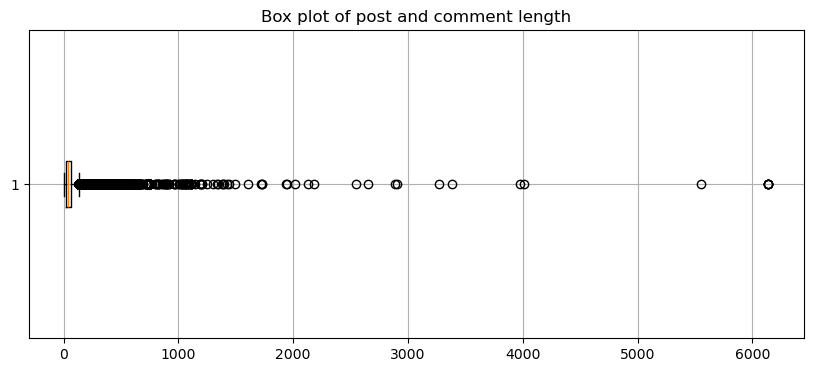

In [26]:
# visalizing post/comment length distribution
plt.figure(figsize=(10, 4))
plt.boxplot(post_length, vert=False)
plt.grid(True)
plt.title('Box plot of post and comment length')
plt.show()

In [27]:
# median value for post and comment length
median_value = statistics.median(post_length)

print(f"The median post/comment length: {median_value}")

The median post/comment length: 36


In [28]:
high_length=yt_data[yt_data['text'].str.len() > 2000]
high_length['text']

5707     ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀...
8287     CB RCB  RCB RCB RCB RCB RCB  RCB RCB RCB RCB R...
10129    Great great great great great great great grea...
16443    Brendon McCullum❤, a former New Zealand cricke...
16704    No anyone can take the place of yuvraj singh.....
17953    70 saal dukhi hua hai aam insaan. 70 saal tak ...
24865    Official *ABBU* OF PAKISTHAN🗿🥶\nVirat Kohli in...
57856    Rohit Sharma (c), Hardik Pandya(vc), Yashasvi ...
57862    Rohit Sharma (c), Hardik Pandya(vc), Yashasvi ...
57863    Rohit Sharma (c), Hardik Pandya(vc), Yashasvi ...
57864    Rohit Sharma (c), Hardik Pandya(vc), Yashasvi ...
57868    Rohit Sharma (c), Hardik Pandya(vc), Yashasvi ...
59795    Virat Kohli in international match--\n\n522 ma...
61720    I love you.\nI love you.\nI love you.\nI love ...
61891    ### 1. **Basic Overview**\nStart with a brief ...
62627    1. M\n2. A\n3. H\n4. I\n5. R\n6. A\n7. T\n8. M...
64196    "ADMIN WATCHING IPL""ADMIN WATCHING IPL""ADMIN.

In [29]:
high_length.shape

(17, 8)

In [30]:
# 17 comments with more than 2000 length and not meaningful
# decided to remove

In [31]:
for text in high_length['text']:
    print(text)
    print("\n" + "="*100 + "\n") 

⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⣄⠀⠀⡠⠠⡤⠤⠄⠀⡠⠄⠄⡀⠀⢀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⣰⣴⣦⣴⣶⣤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣆⠠⠁⠀⡇⠀⠀⢸⠁⠀⢀⡅⢀⠮⢧⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣤⣴⣶⣶⣶⣶⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠄⠀⠺⠃⠀⠀⠧⠤⠔⠈⠃⠤⠼⠃⠎⠀⠈⠇⠀
⠀⠀⠀⠀⠀⠀⠀⠀⢀⣴⣶⣦⣼⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡍⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠰⠘⠉⠡⠈⠉⠄⠀⠷⠯⠿⠗⠇⠄⠌⠠⠌⠡⠄⠀
⠀⠀⠀⠀⠀⠀⠤⣴⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣦⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⣠⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⣰⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⣰⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠋⠋⠀⠀⠀⢡⠘⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠸⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⠟⠃⠀⠀⠀⠀⠀⠀⢀⡘⠤⣿⣿⣿⣿⣿⣿⣿⣿⣿⡀⠀⠀⡘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠰⢨⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠟⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠐⠢⡙⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀⢠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠙⢿⣿⣿⣿⣿⡿⢋⠍⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⢁⠂⠏⢿⣿⣿⣿⣿⣿⣿⣿⡟⠀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⡀⠀⠈⠙⣿⣿⡿⣡⢃⠌⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠖⣉⣤⣬⡈⠘⡄⢊⠿⣿⣿⣿⣿⡿⣧⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠐⠿⣿⣿⣱⠊⡔⠀⠀⠀⠀⠀⠀⠀⣠⣦⣶⣷⣿⠿⣛⣭⣽⢗⣈⠂⠢⢙⣿⣿⡟⢡⠏⣟⢧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠫⣿⣿⣮⠱⡄⢂⠀⠀⡀⠀⢰⣾⣿⣿⣿⣿⣿⣽⣿⣿⡿⠗⠀⠀⠁⠢⢸⣿⣧⣸⣦⡘⣜⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠻⢿⣡⣾⣷⣶⣶⣿⡷⠟⠛⠻⠟⠿⠻⢶⡛⠳⠋⠀⠀⠀⠀⠀⠂⠥⢹⣿⣧⣱⣱⢱⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

In [32]:
yt_data=yt_data[yt_data['text'].str.len() < 2000]

In [33]:
high_length2=yt_data[yt_data['text'].str.len() > 1000]
high_length2['text']

815      This world cup mostly simulated like ICC champ...
3358     football/ soccer the least talented, overrated...
6772     Life I have a dream, one day I will be a big c...
10056    This unforgettable day, June 29, 2024, will fo...
11367    India🇮🇳 T20 playing 11 for T20 World Cup🏆\n1) ...
13182    Shiv ji ke 108 naam:\n\n1. शिव\n2. महेश्वर\n3....
14566    Shiv ji ke 108 naam:\n\n1. शिव\n2. महेश\n3. शं...
15875    save Bangladesh students \n\nWe (Bangladeshi) ...
15876    save Bangladesh students \n\nWe (Bangladeshi) ...
15877    save Bangladesh students \n\nWe (Bangladeshi) ...
15878    save Bangladesh students \n\nWe (Bangladeshi) ...
15879    save Bangladesh students \n\nWe (Bangladeshi) ...
17051    This is the worst tournament  ever organised b...
18502    If they do it for Kenya n dozens of other sub ...
18883    Subject: Visa Application for Mr. Sandeep Lami...
23558    Positives for each team in T20 World Cup 2024 ...
23671    Really happy to see ICC promoting associating .

In [34]:
for i,text in enumerate(high_length2['text']):
    print(text)
    print(f"Comment no {i}")
    print("\n" + "="*100 + "\n") 

This world cup mostly simulated like ICC champions trophy finals 2013

1)India lost early wickets(IND 66/5 in CT13 finals,IND 34/3 in T20WC24 finals) 
2)Kohli played a great knock in both the finals(Kohli 43(34) in CT13,Kohli 76(59) in T20WC24)
3)Left arm spinner and allrounder played crucial innings with Kohli in both(Jadeja33(25) in CT13,Axar Patel 47(31)in T20WC24)
4) Opponent team lost early wickets (England were 47/4 in CT13,SA 12/2 in T20WC24)
5)Heart breaking partnership for 5th wicket in both games(Morgan and bopara in CT13,Miller and Klaseen in T20WC24)
6)Death over thriller (England needed only 20 Runs in 16 balls with 6 wickets in hand in CT 2013 finals,SA needed 26 runs in 24 balls with 6 wickets in hand in T20WC 2024 finals)
7)Great comeback of India from there
8)Last over 15 of 6 in CT13,16 of 6 in T20WC24 
9)Four in 19.2 nd ball in both the finals(By Fast bowler broad in CT13,Fast bowler Rabada in T20WC24)
10)ENG lost 8 wickets in CT13,SA lost 8 wickets in T20WC24.
11)IN

In [35]:
ignore_index = [13182,14566,15875,15876,15877,15878,15879,18883,23671,23675,25674, 27143,32711,32846,40175,54957,54958,55597,56822]

In [36]:
for index in ignore_index:
    text_value = yt_data.loc[index, 'text']
    print(f"Text for index {index}:")
    print(text_value)
    print("\n" + "="*100 + "\n")  

Text for index 13182:
Shiv ji ke 108 naam:

1. शिव
2. महेश्वर
3. शम्भू
4. पिनाकी
5. शशिशेखर
6. वामदेव
7. विरूपाक्ष
8. कपर्दी
9. नीललोहित
10. शंकर
11. शूलपाणि
12. खट्वाङ्गी
13. विष्णुवल्लभ
14. शिपिविष्ट
15. अंबिकानाथ
16. श्रीकण्ठ
17. भक्तवत्सल
18. भव
19. शर्व
20. त्रिलोकेश
21. शितिकण्ठ
22. शिवाप्रिय
23. उग्र
24. कपाली
25. कामारी
26. अंधकासुरसूदन
27. गङ्गाधर
28. ललाटाक्ष
29. कालकाल
30. कृपानिधि
31. भीम
32. परशुहस्त
33. मृगपाणि
34. जटाधर
35. कैलाशवासी
36. कवची
37. कठोर
38. त्रिपुरान्तक
39. वृषांक
40. वृषभारूढ़
41. भस्मोद्धूलितविग्रह
42. सामप्रिय
43. स्वरमयी
44. त्रयीमूर्ति
45. अनीश्वर
46. सर्वज्ञ
47. परमात्मा
48. सोमसूर्याग्निलोचन
49. हविर्यज्ञमय
50. सोम
51. पंचवक्त्र
52. सदाशिव
53. विश्वेश्वर
54. वीरभद्र
55. गणनाथ
56. प्रजापति
57. हिरण्यरेता
58. दुर्धर्ष
59. गिरीश
60. गिरिश
61. अनघ
62. बुग्ण
63. लिंगाध्यक्ष
64. सूर्यतपन
65. दक्षाध्वरहर
66. हर
67. भवपत
68. लिंगाचार्य
69. देवीश्वर
70. श्रीकण्ठधारक
71. श्रीधर
72. नन्दिकेश्वर
73. श्रीकण्ठधार
74. श्रीकण्ठविभूषण
75. नन्दिकेश
76. श्रीकण्ठप्रिय


In [37]:
yt_data = yt_data.drop(index=ignore_index)

In [38]:
# confirm removing meaningless comments with more than 1000 characters
high_length2=yt_data[yt_data['text'].str.len() > 1000]
high_length2['text']

815      This world cup mostly simulated like ICC champ...
3358     football/ soccer the least talented, overrated...
6772     Life I have a dream, one day I will be a big c...
10056    This unforgettable day, June 29, 2024, will fo...
11367    India🇮🇳 T20 playing 11 for T20 World Cup🏆\n1) ...
17051    This is the worst tournament  ever organised b...
18502    If they do it for Kenya n dozens of other sub ...
23558    Positives for each team in T20 World Cup 2024 ...
26344    Lemmie remind everyone of something, with 80 r...
27402    We love the general Indians, and we appreciate...
30625    Most underrated reason for Australia winning w...
31120    football/ soccer the least talented, overrated...
34473    This unforgettable day, June 29, 2024, will fo...
36535    This world cup finals mostly simulated like IC...
40794    Bumra you can bowl phil salt but why can't you...
44514    😎QUESTION OF CRICKET YUGG🏏 \n\nKindly make thi...
45397    The Great Kumar sangakkara - The best test bat.

In [39]:
# 500-1000 characters
high_length3=yt_data[(yt_data['text'].str.len() > 500) & (yt_data['text'].str.len() < 1000)]

In [40]:
for index,row in high_length3.iterrows():
    print(f"Comment : {row['text']}")
    print(f"Index : {index}")
    print("\n" + "="*100 + "\n") 

Comment : कमल सिङ्ग आइरी सङ्ग बलिङ र ब्याटिङ को पनि क्षमता रहेछ उसलाइ चान्स  दिनु पर्ने थ्यो । अलराउन्डरको भुमिका लाई मध्यनजर गरौ । अबिनास र बिबेक लाई बेन्च मा राखेनी हुनि ।करिब ६ बर्ष देखि कुनै एउटा पनि खेल नछुटाएर हेरेको आधारमा भन्नुपर्दा पछिल्लो समय नेपाली खेलाडी छनोट कर्ताहरु खेलाडी छनोटमा १००% चुकिरहेको छ।जसले गर्दा नतिजा आफ्नो पक्षमा आउन सकेको छैन।
हुन त टिम म्यानेजमेन्टमा एक से एक खेल विज्ञगरु होलान् तर उनीहरुले खेलाडीको सहि मुल्यांकन र खेलाडीको सिप,क्षमाताको र सम्भाबनाको पहिचान गर्न सकेको छ जस्तो लाग्दैन।
कसैलाई मेरो कुरा अचम्म लाग्छ भने म बिस्तारमा भन्न सक्छु किन के कारणले भनेर।
यदि यहि पाराले अघि बढ्ने हो भने विश्व कप हाम्रो लागि हात्ती आयो हात्ती आयो फुस्स भनेझै हुने कुरा निस्चित छ! अनिल शाहलाई सिधै स्क्वाडमा नराख! अनिल शाहको नाम देखाएर तिमेरु ले अन्तिममा खेलाउने भनेको उहीँ विनाश बोहोरा, भुर्तेल, लाई नै हो!
Index : 1052


Comment : कमल सिङ्ग आइरी सङ्ग बलिङ र ब्याटिङ को पनि क्षमता रहेछ उसलाइ चान्स  दिनु पर्ने थ्यो । अलराउन्डरको भुमिका लाई मध्यनजर गरौ । अबिनास र बिबेक लाई बेन्

In [41]:
ignore_index = [1052,1061,1263,10164,11349,11370,12710,12729,12984,13784,19238,24242,26133,27106,
               27107,28379,28392,28422,32548,35622,36881,47383,47402,47403,47404,47408,50440,50446,51978,52542,52910,59371,59372,
                61937,62879,63820]

In [42]:
yt_data = yt_data.drop(index=ignore_index)

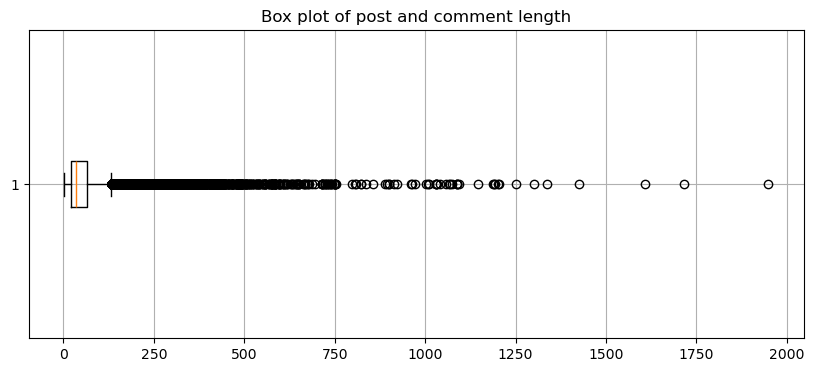

In [43]:
# post and comment length
post_length = []

for body in yt_data['text']:
    post_length.append(len(body))
    
# visalizing post/comment length distribution
plt.figure(figsize=(10, 4))
plt.boxplot(post_length, vert=False)
plt.grid(True)
plt.title('Box plot of post and comment length')
plt.show()

In [44]:
yt_data.head()

,video_id,video_title,video_published_at,comment_id,author,published_at,like_count,text
0,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01 00:03:10+00:00,UgzEN6KIn3XOG3vyDkp4AaABAg,@Griffinatus,2024-07-01 01:58:37+00:00,9300,The innings by kohli.\nThe innings by axar.\nT...
1,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01 00:03:10+00:00,UgzEFVkhnorEOn6Jhbh4AaABAg,@_Joyboy1,2024-07-01 00:41:02+00:00,3115,Happy retirement ROKO and sir jadeja🧎💐
2,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01 00:03:10+00:00,UgwV1P6xqTATKEqD9v94AaABAg,@Champ_Akash,2024-07-01 00:05:50+00:00,2611,Happy retirement ROKO from T20I ❤❤\nAnd we can...
3,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01 00:03:10+00:00,UgyKudsaT_Rm_L_O4RN4AaABAg,@farellesmanff6072,2024-07-01 02:08:33+00:00,1211,*Nothing more satisfying than hearing a crowd ...
4,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01 00:03:10+00:00,UgzJZCKBR4ItiNrDD154AaABAg,@diptiborthakurdas3275,2024-07-01 08:13:16+00:00,781,'Mummy ka magic' worked🥺🥺


In [45]:
# defining a function to tokenize data
def data_tokenizer(text, tokenizer):

    token_list = tokenizer.tokenize(text)
    token_list = [token.strip() for token in token_list]

    return token_list

In [46]:
# initializing the necessary components
tokenizer = nltk.tokenize.TweetTokenizer()
punctuations = list(string.punctuation)
lStopwords = nltk.corpus.stopwords.words('english') + punctuations + ['...','']
stemmer = nltk.stem.PorterStemmer()
lemmatizer = WordNetLemmatizer()
vader_analyzer = SentimentIntensityAnalyzer()

In [47]:
# defining the dictionary for pos tag mapping
pos_map = {'ADJ':'a','ADP':'s','ADV':'r','NOUN':'n','VERB':'v'}

In [48]:
# generating tokens

# to store tokens
tokens =[]

# defining a counter to count the tokens
termFreqCounter = Counter()

for body in yt_data['text']:
    temp_tokens = data_tokenizer(body,tokenizer)
    tokens.append(temp_tokens)
    termFreqCounter.update(temp_tokens)

In [49]:
# checking tokens list
tokens[1]

['Happy', 'retirement', 'ROKO', 'and', 'sir', 'jadeja', '🧎', '💐']

In [50]:
# observing token counts for 50 most common tokens
for term, count in termFreqCounter.most_common(50):
    print(term + ': ' + str(count))

❤: 25914
😂: 15275
the: 14093
.: 13936
,: 11442
is: 9249
in: 8564
to: 8045
of: 7998
and: 7173
a: 6848
🇮🇳: 6233
for: 5795
🎉: 4931
India: 4615
...: 4558
this: 4429
️: 4386
I: 3941
🔥: 3656
!: 3599
team: 3435
😢: 3367
world: 3230
was: 3106
hai: 3005
you: 2931
from: 2839
that: 2759
😅: 2711
cup: 2700
cricket: 2679
?: 2601
match: 2551
it: 2471
he: 2440
like: 2437
Pakistan: 2422
😊: 2418
are: 2398
..: 2359
be: 2234
not: 2192
will: 2185
on: 2142
win: 2139
The: 1990
-: 1964
but: 1904
all: 1890


C:\Users\sppag\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sppag\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127475 (\N{REGIONAL INDICATOR SYMBOL LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sppag\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sppag\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


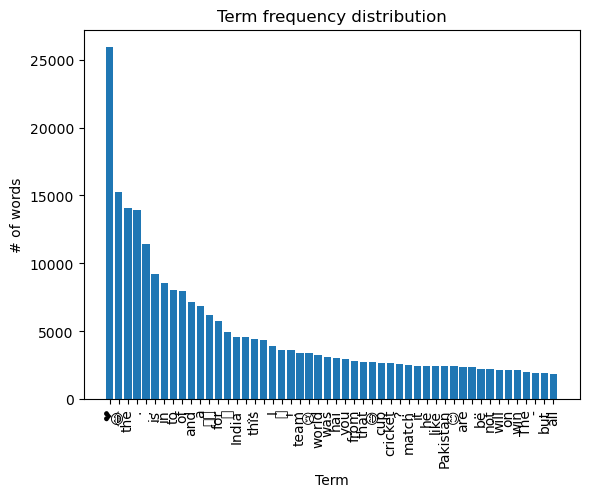

In [51]:
# plotting most common term counts
y = [count for tag, count in termFreqCounter.most_common(50)]
x = [tag for tag, count in termFreqCounter.most_common(50)]

plt.bar(x, y)
plt.title("Term frequency distribution")
plt.ylabel('# of words')
plt.xlabel('Term')
plt.xticks(rotation = 90)
plt.show()

In [82]:
# defining a function for pre-processing

def preprocessor_lemmatizer(text):
    # remove unicode character
    text = re.sub(u"(\u2018|\u2019|\u2014|\u2026|\u201d|\u201c|\ud83e|\udd14|U+002E|U+002E|=/|\.{2,})", "",text)
    # tokenization
    token_list = tokenizer.tokenize(text)
    # strip white spaces
    token_list = [token.strip() for token in token_list]
    # converting to lowercase
    token_list = [token.lower() for token in token_list]

    # to identify numbers (both decimal and real numbers)
    digit_pattern = re.compile(r"\b\d+(\.\d+)?\b")
    # to identify links
    link_pattern = re.compile(r'^http.*|.*\.com|^www.*')
    # to identify tokens with mixed letters and digits
    digit_letter_mix_pattern = re.compile(r"^(?=.*[A-Za-z])(?=.*\d)[A-Za-z\d]+$")
    
    hindi_words = [
    'hai', 'ka', 'ko', 'ki', 'ke', 'kaun', 'kya', 'bhi', 'nahi', 'nhi', 'se','ji','aaj', 'rha', 
    'tha', 'ho', 'hain', 'aur', 'ne', 'ho', 'le', 'gaya', 'na', 'jo', 'ka', 'से','bhai','hi',
    'tha', 'kuch', 'kya', 'ka', 'se', 'sab', 'bhi', 'kaun', 'kyon', 'diya', 'dekh','की',
    'ye', 'raha', 'hai', 'hota', 'ho', 'ka', 'le', 'yeh', 'jo', 'mein', 'को','में','और', 
    'ho', 'gaya', 'ka', 'kaun', 'aur', 'hai', 'nahi', 'ke', 'se','है','jai','के','का','baap','भी'
    ]

    token_list = [token for token in token_list if token not in lStopwords and digit_pattern.match(token) == None and link_pattern.match(token) == None and digit_letter_mix_pattern.match(token) == None and token.strip()]

    token_list = [token for token in token_list if token not in hindi_words]
    
    # identify pos tags
    tags = pos_tag(token_list, tagset='universal')

    # mapping to a readble pos tag format for lemmatizer
    tags = [(token,pos_map[tag] if tag in pos_map.keys() else 'n')for (token,tag) in tags]

    # lemmatizations
    token_list = [lemmatizer.lemmatize(token,tag) for (token,tag) in tags]
    
    # remove single letter tokens
    token_list = [token for token in token_list if len(token)>1]

    return token_list

In [83]:
# applying pre-processing

# defining a counter to count the frequency of tokens
termFreqCounter = Counter()

preprocessed_tokens = []

for body in tqdm(yt_data['text']):
    temp_tokens = preprocessor_lemmatizer(body)
    preprocessed_tokens.append(temp_tokens)
    termFreqCounter.update(temp_tokens)

  0%|          | 0/69169 [00:00<?, ?it/s]

In [84]:
# observing token counts for 50 most common tokens
for term, count in termFreqCounter.most_common(50):
    print(term + ': ' + str(count))

india: 6869
🇮🇳: 6233
world: 4818
team: 4398
cup: 4178
cricket: 3539
match: 3320
icc: 3273
pakistan: 3072
win: 2991
like: 2713
best: 2508
kohli: 2430
indian: 2327
love: 2306
rohit: 2204
bumrah: 2183
final: 2055
play: 1982
wc: 1970
time: 1964
one: 1863
player: 1800
king: 1791
virat: 1709
🇧🇩: 1696
ball: 1647
well: 1602
great: 1575
good: 1567
catch: 1488
australia: 1424
bangladesh: 1402
wicket: 1368
bowler: 1343
get: 1317
run: 1295
fan: 1288
game: 1270
afghanistan: 1240
make: 1183
see: 1178
go: 1163
video: 1150
sharma: 1126
six: 1096
watch: 1086
trophy: 1071
nepal: 1071
please: 1045


In [67]:
# from langdetect import detect

# import nltk
# from nltk.corpus import words
# nltk.download('words')

# can not used

In [86]:
# defining a pre-processor for vader
def vader_pre_processor(text):
    tokens = tokenizer.tokenize(text)

    # removing digits
    digit_pattern = re.compile(r"\b\d+(\.\d+)?\b")
    # removing links
    link_pattern = re.compile(r'^http.*|.*\.com|^www.*')
    # hindi words
    hindi_words = [
    'hai', 'ka', 'ko', 'ki', 'ke', 'kaun', 'kya', 'bhi', 'nahi', 'nhi', 'se','ji','aaj', 'rha', 
    'tha', 'ho', 'hain', 'aur', 'ne', 'ho', 'le', 'gaya', 'na', 'jo', 'ka', 'से','bhai','hi',
    'tha', 'kuch', 'kya', 'ka', 'se', 'sab', 'bhi', 'kaun', 'kyon', 'diya', 'dekh','की',
    'ye', 'raha', 'hai', 'hota', 'ho', 'ka', 'le', 'yeh', 'jo', 'mein', 'को','में','और', 
    'ho', 'gaya', 'ka', 'kaun', 'aur', 'hai', 'nahi', 'ke', 'se','है','jai','के','का','baap','भी'
    ]

    # filtering tokens
    tokens = [token.strip() for token in tokens if token not in hindi_words and digit_pattern.match(token)==None and link_pattern.match(token)==None and token.strip()]

    # joining tokens togeter
    text = ' '.join(tokens)

    return text

In [87]:
#apply vader preprocessing
vader_tokens = []

for body in tqdm(yt_data['text']):
    temp_tokens = vader_pre_processor(body)
    vader_tokens.append(temp_tokens)

  0%|          | 0/69169 [00:00<?, ?it/s]

In [90]:
preprocessed_tokens = [" ".join(token) for token in preprocessed_tokens]
yt_data.loc[:, 'Processed_1'] = preprocessed_tokens
yt_data.loc[:, 'Processed_2'] = vader_tokens

In [91]:
yt_data.head()

,video_id,video_title,video_published_at,comment_id,author,published_at,like_count,text,Processed_1,Processed_2
0,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01 00:03:10+00:00,UgzEN6KIn3XOG3vyDkp4AaABAg,@Griffinatus,2024-07-01 01:58:37+00:00,9300,The innings by kohli.\nThe innings by axar.\nT...,inning kohli inning axar finish touch shivam t...,The innings by kohli . The innings by axar . T...
1,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01 00:03:10+00:00,UgzEFVkhnorEOn6Jhbh4AaABAg,@_Joyboy1,2024-07-01 00:41:02+00:00,3115,Happy retirement ROKO and sir jadeja🧎💐,happy retirement roko sir jadeja,Happy retirement ROKO and sir jadeja 🧎 💐
2,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01 00:03:10+00:00,UgwV1P6xqTATKEqD9v94AaABAg,@Champ_Akash,2024-07-01 00:05:50+00:00,2611,Happy retirement ROKO from T20I ❤❤\nAnd we can...,happy retirement roko can't forget rahul dravi...,Happy retirement ROKO from T20I ❤ ❤ And we can...
3,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01 00:03:10+00:00,UgyKudsaT_Rm_L_O4RN4AaABAg,@farellesmanff6072,2024-07-01 02:08:33+00:00,1211,*Nothing more satisfying than hearing a crowd ...,nothing satisfy hearing crowd go soundful _roh...,* Nothing more satisfying than hearing a crowd...
4,-2fjXRxMh-c,The euphoria of a #T20WorldCup trophy in your ...,2024-07-01 00:03:10+00:00,UgzJZCKBR4ItiNrDD154AaABAg,@diptiborthakurdas3275,2024-07-01 08:13:16+00:00,781,'Mummy ka magic' worked🥺🥺,mummy magic work,' Mummy magic ' worked 🥺 🥺


In [97]:
yt_data.shape

(69169, 10)

In [96]:
# sentiment analysis

In [141]:
# computing sentimenet for each comment/post
vader_sentiments = []

for index,row in tqdm(yt_data.iterrows(),total=69169):
    
    #apply pre-processing
    text = row['Processed_2']
    
    #vader polarity score
    vader_score = vader_analyzer.polarity_scores(text)
    
    #time for the comment
    comment_date = row['published_at']
    
    vader_sentiments.append([comment_date, vader_score['compound']])

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/69169 [00:00<?, ?it/s]

In [142]:
# converting to dataframe
t20_sentiment = pd.DataFrame(vader_sentiments,columns=["Date_time","Sentiment"])
t20_sentiment['Date_time']=pd.to_datetime(t20_sentiment['Date_time'])
t20_sentiment['Date_time']=t20_sentiment['Date_time'].dt.date

#aggregating
t20_sentiment_aggregated = t20_sentiment.groupby('Date_time')['Sentiment'].mean().reset_index()

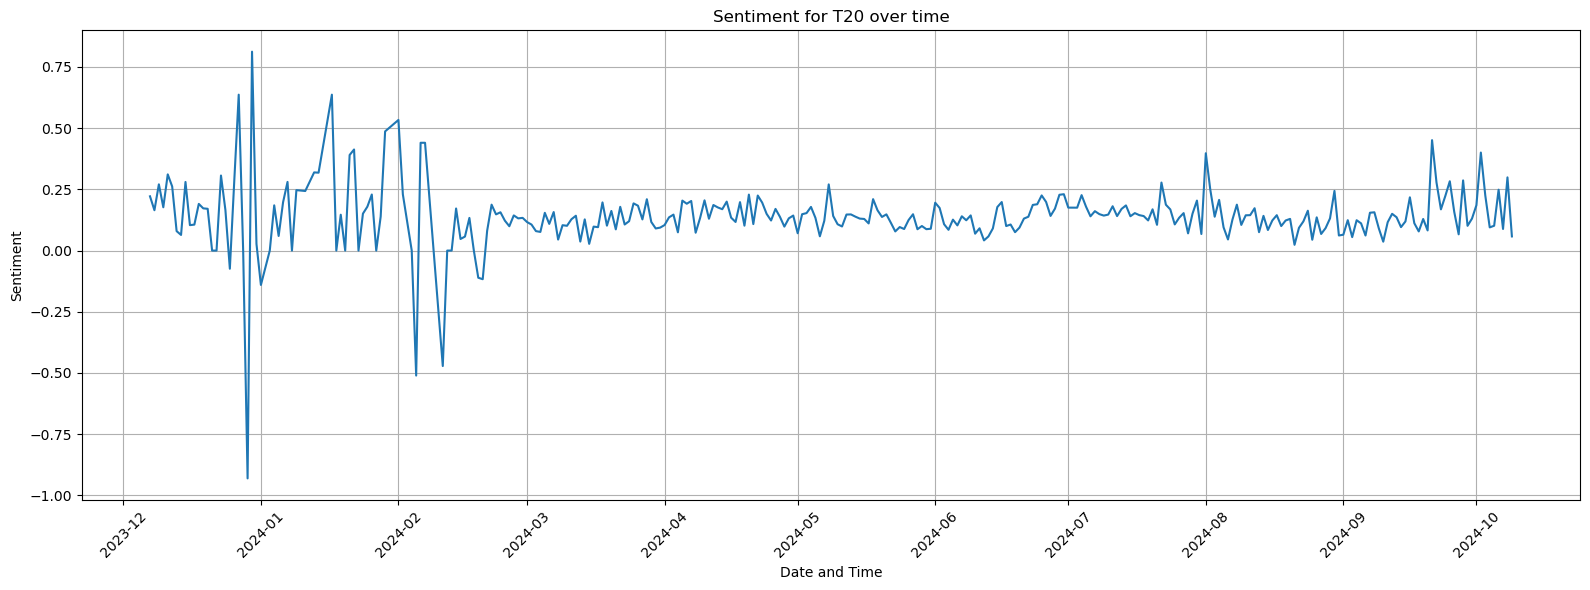

In [143]:
# plotting sentiment
plt.figure(figsize=(16, 6))
plt.plot(t20_sentiment_aggregated['Date_time'],t20_sentiment_aggregated['Sentiment'],linestyle='-')
plt.title('Sentiment for T20 over time')
plt.xlabel('Date and Time')
plt.ylabel('Sentiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# exploring sentiments below -0.25

In [166]:
t20_sentiment_aggregated[t20_sentiment_aggregated['Sentiment']<-0.25]

,Date_time,Sentiment
22,2023-12-29,-0.9307
52,2024-02-05,-0.5106
55,2024-02-11,-0.4717


In [175]:
date_filter = ((yt_data['published_at'].dt.date == datetime(2023, 12, 29).date()) | 
               (yt_data['published_at'].dt.date == datetime(2024, 2, 5).date()) | 
               (yt_data['published_at'].dt.date == datetime(2024, 2, 11).date()))

In [173]:
date_filter = ((yt_data['published_at'].dt.date == datetime(2024, 2, 5).date()) | 
               (yt_data['published_at'].dt.date == datetime(2024, 2, 11).date()))

In [176]:
low_sentiment=yt_data[date_filter]
low_sentiment

,video_id,video_title,video_published_at,comment_id,author,published_at,like_count,text,Processed_1,Processed_2
11214,8L3QSt6f3dM,The ICC T20 World Cup gets a brand new makeover,2023-12-07 07:07:30+00:00,Ugw8mhfh7FEdIjsZGr94AaABAg,@sahiljadhav3225,2024-02-05 05:02:06+00:00,1,"ICC please upload, ICC World Cup 2023 final ma...",icc please upload icc world cup final match in...,"ICC please upload , ICC World Cup final match ..."
11267,8L3QSt6f3dM,The ICC T20 World Cup gets a brand new makeover,2023-12-07 07:07:30+00:00,UgxrQjMIK8bIE3HuT8N4AaABAg,@naturalbeauty8913,2023-12-29 11:10:21+00:00,1,ICC deserve the most Stupid decision makers aw...,icc deserve stupid decision maker award year e...,ICC deserve the most Stupid decision makers aw...
11438,8L3QSt6f3dM,The ICC T20 World Cup gets a brand new makeover,2023-12-07 07:07:30+00:00,UgxkooRmAo2juxpWS-J4AaABAg,@akash.das.channel,2024-02-11 17:31:53+00:00,0,Not expected Ind win,expect ind win,Not expected Ind win


In [177]:
for text in low_sentiment['text']:
    print(text)

ICC please upload, ICC World Cup 2023 final match India vs Australia. If FIFA can upload their final matches on YouTube then who the hell are you
ICC deserve the most Stupid decision makers award in the year end as well because It is unable to change stupid Umpire's Call decision. 

When will this Stupid Decision be changed by Stupid Management of ICC as it is impacting Each and Every match.

Really Disgraceful. 
Pathetic. 😡
Not expected Ind win


In [178]:
for text in low_sentiment['video_title']:
    print(text)

The ICC T20 World Cup gets a brand new makeover
The ICC T20 World Cup gets a brand new makeover
The ICC T20 World Cup gets a brand new makeover


In [105]:
# Topic modelling

In [107]:
comment_text = yt_data['Processed_1'].tolist()

In [116]:
# creating the count vectorzer object
tfVectorizer = CountVectorizer(max_df=0.95, min_df=50, stop_words='english')
# generating the count vector
tf = tfVectorizer.fit_transform(comment_text)
# list of words in count vector
tfFeatureNames = tfVectorizer.get_feature_names_out()

In [115]:
# no of words in count vector
len(tfFeatureNames)

762

In [117]:
# define an array to check different topic counts
num_topics = [2, 3, 5, 8, 10, 15, 20, 30]
# defining an empty array to store log-liklihood scores
log_likelihood_scores = []

# creating LDA models for each topic count and storing the log-likelihood score
for num_topic in tqdm(num_topics, total=len(num_topics)):

    ldaModel = LatentDirichletAllocation(n_components =num_topic, max_iter=10, learning_method='online',random_state=100).fit(tf)
    log_likelihood_score = ldaModel.score(tf)
    log_likelihood_scores.append([num_topic, log_likelihood_score])

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/8 [00:00<?, ?it/s]

In [118]:
log_likelihood_scores

[[2, -1565599.8240957316],
 [3, -1566736.6743350439],
 [5, -1602627.1298991204],
 [8, -1613124.3285135117],
 [10, -1623768.4949054974],
 [15, -1638818.556765961],
 [20, -1654623.5286631524],
 [30, -1668824.1667578523]]

In [127]:
# checking for topic count of 2
ldaModel = LatentDirichletAllocation(n_components =2, max_iter=10, learning_method='online', random_state=100).fit(tf)
# visualization for topic count 2
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [128]:
# checking for topic count of 3
ldaModel = LatentDirichletAllocation(n_components =3, max_iter=10, learning_method='online', random_state=100).fit(tf)
# visualization for topic count 3
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [129]:
# checking for topic count of 4
ldaModel = LatentDirichletAllocation(n_components =4, max_iter=10, learning_method='online', random_state=100).fit(tf)
# visualization for topic count 4
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [130]:
# checking for topic count of 5
ldaModel = LatentDirichletAllocation(n_components =5, max_iter=10, learning_method='online', random_state=100).fit(tf)
# visualization for topic count 5
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [131]:
# checking for topic count of 10
ldaModel = LatentDirichletAllocation(n_components =10, max_iter=10, learning_method='online', random_state=100).fit(tf)
# visualization for topic count 10
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [135]:
# <!-- 4 topics is more meaningful

# Topic 1 : International Cricket Rivalries and Celebrations of Major Wins in Global Tournaments 
# Topic 2 : Key Performances and Critical Moments in World Cup Finals
# Topic 3 : "Fans’ Admiration for Indian Cricketers and Memorable Moments
# Topic 4 : Celebrating Cricket Legends and Iconic Moments T20 Cricket
# Topic 5 : Comparing Star Batsmen of India and Pakistan -->

In [132]:
topic1_words = ['win','revenge','champion','team','love']
topic2_words = ['wc', 'final','india', 'africa']
topic3_words = ['rohit', 'sharma','yuvraj', 'singh' ,'fan']
topic4_words = ['legend','highlight','king','dhoni']
topic5_words = ['kohli','babar','virat','azam']

In [185]:
# defining  a function to compute sentiment for each topic
def topic_sentiments(topic_words,start_date,end_date):

    topic_sentiments = []

    for index,row in tqdm(yt_data.iterrows(),total=69169):

        text = row['Processed_1']

        # identifuing the key words present in the post
        if any(word in text for word in topic_words):

            vader_score = vader_analyzer.polarity_scores(row['Processed_2'])

            comment_date = row['published_at']

            topic_sentiments.append([comment_date, vader_score['compound']])

    # aggregating the sentiment on daily basis
    topic_df = pd.DataFrame(topic_sentiments,columns=["Date","Sentiment"])
    topic_df['Date'] = pd.to_datetime(topic_df['Date'])
    topic_df['Date'] = topic_df['Date'].dt.date
    topic_aggregated_df = topic_df.groupby('Date')['Sentiment'].mean().reset_index()
    topic_aggregated_df['Date'] = pd.to_datetime(topic_aggregated_df['Date'])
    # defining a date filter
    date_filter = ((topic_aggregated_df['Date'] > datetime(start_date['year'], start_date['month'], start_date['day'])) & 
               (topic_aggregated_df['Date'] < datetime(end_date['year'], end_date['month'], end_date['day'])))
    #applying date filter
    topic_aggregated_df = topic_aggregated_df[date_filter]

    # creating the plot
    plt.figure(figsize=(16, 6))
    plt.plot(topic_aggregated_df['Date'], topic_aggregated_df['Sentiment'], linestyle='-')
    plt.title('Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sentiment')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [186]:
start_date = {'year': 2023, 'month': 12, 'day': 1}
end_date = {'year': 2024, 'month': 10, 'day': 9}

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/69169 [00:00<?, ?it/s]

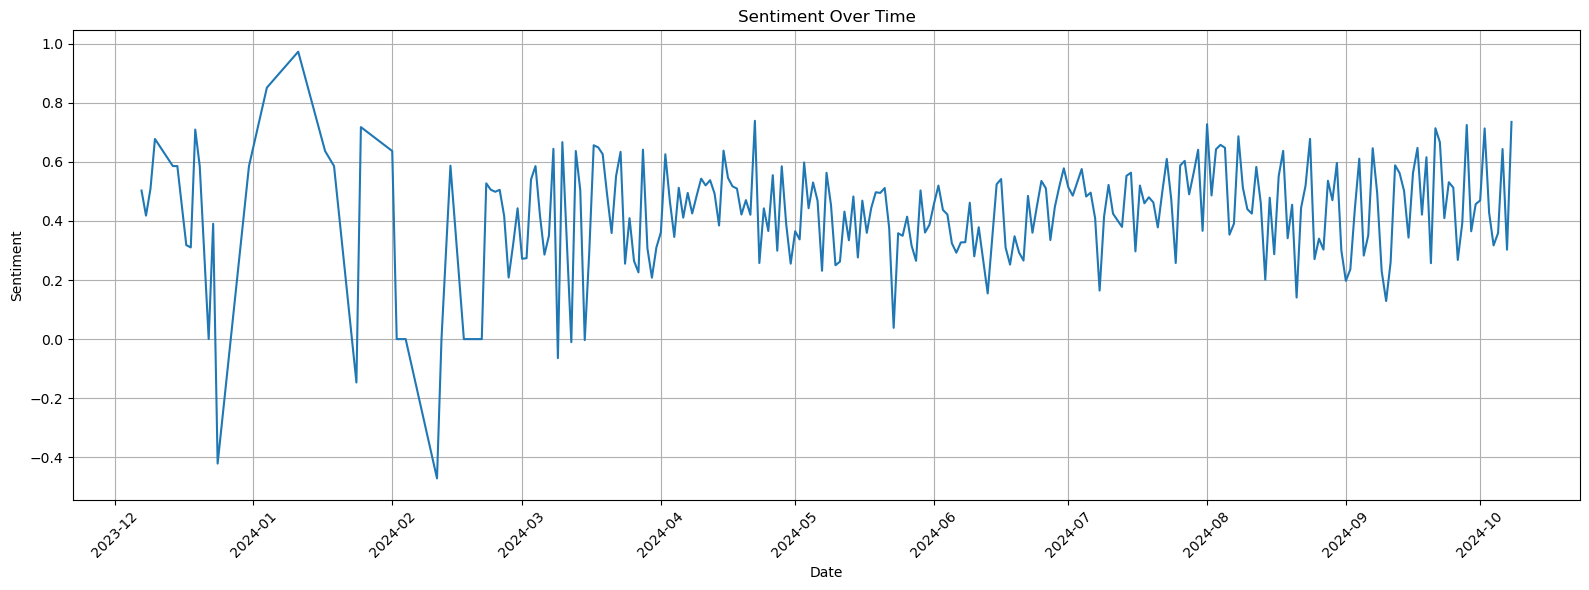

In [187]:
# sentiment for topic 1

topic_sentiments(topic1_words,start_date,end_date)

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/69169 [00:00<?, ?it/s]

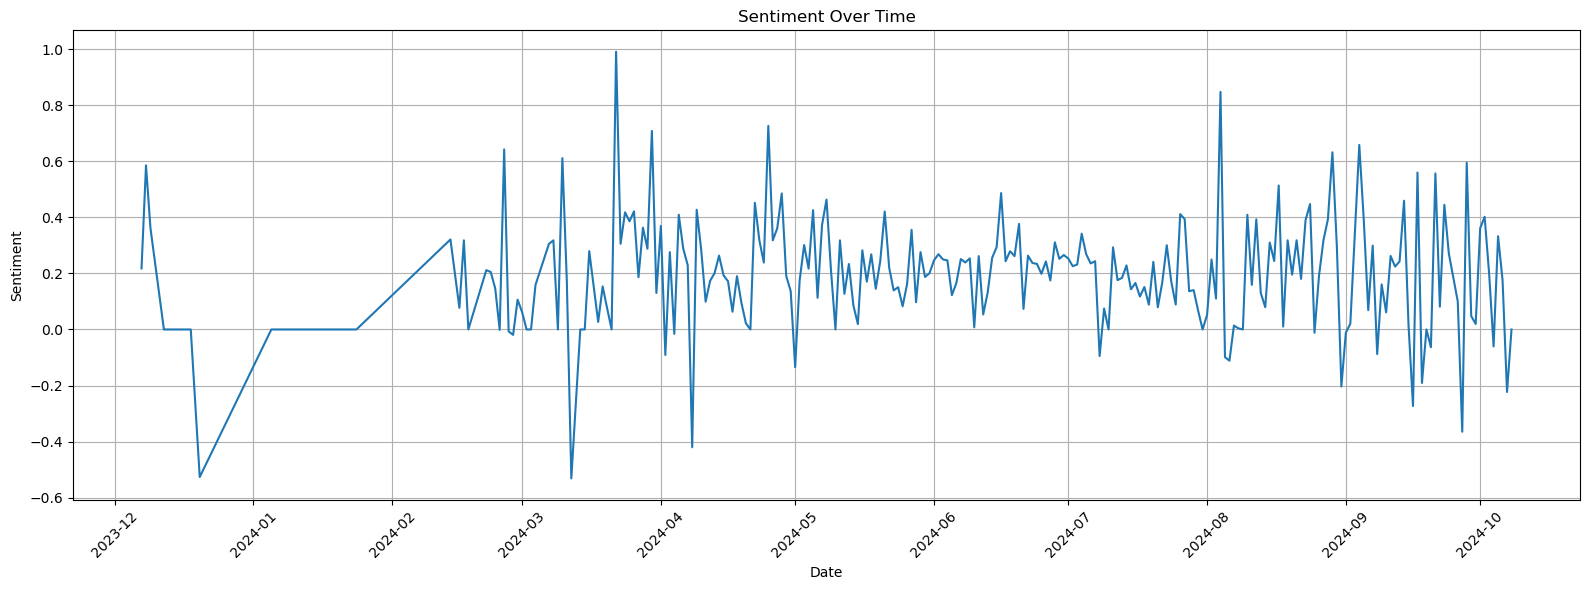

In [188]:
# sentiment for topic 3

topic_sentiments(topic3_words,start_date,end_date)

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/69169 [00:00<?, ?it/s]

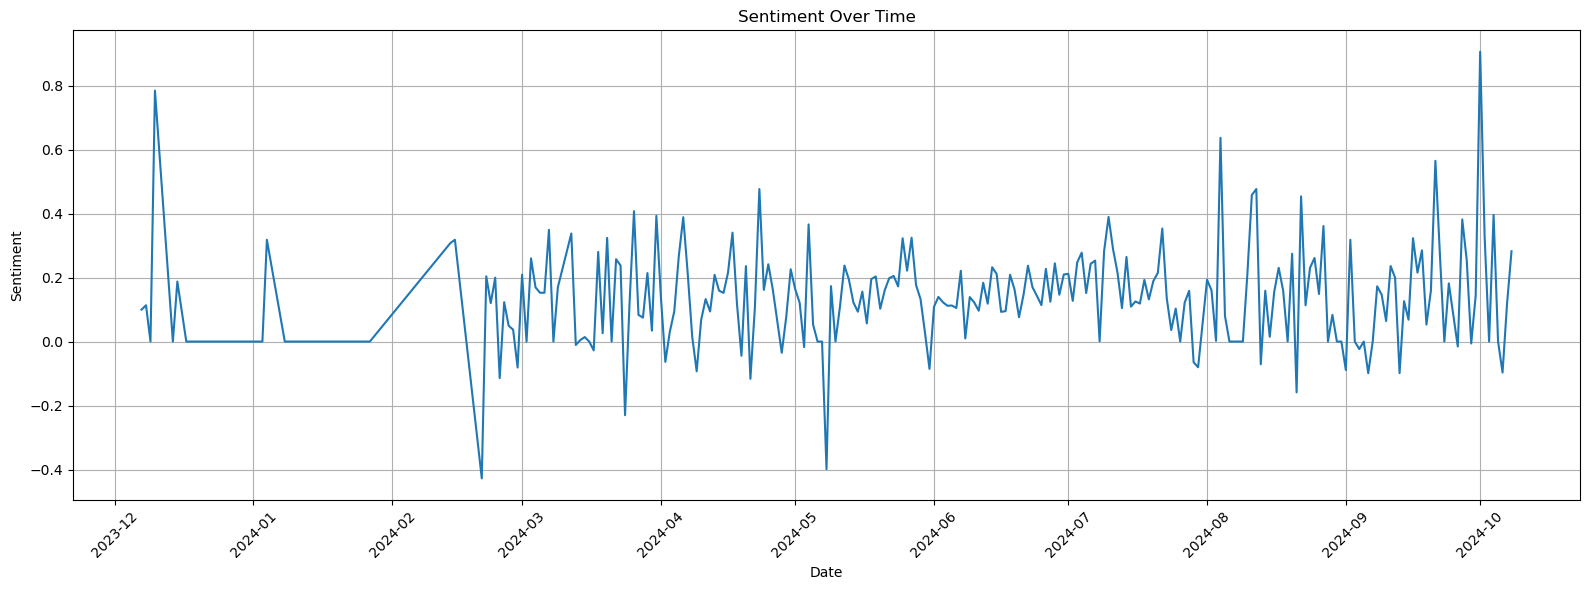

In [189]:
# sentiment for topic 4

topic_sentiments(topic4_words,start_date,end_date)

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/69169 [00:00<?, ?it/s]

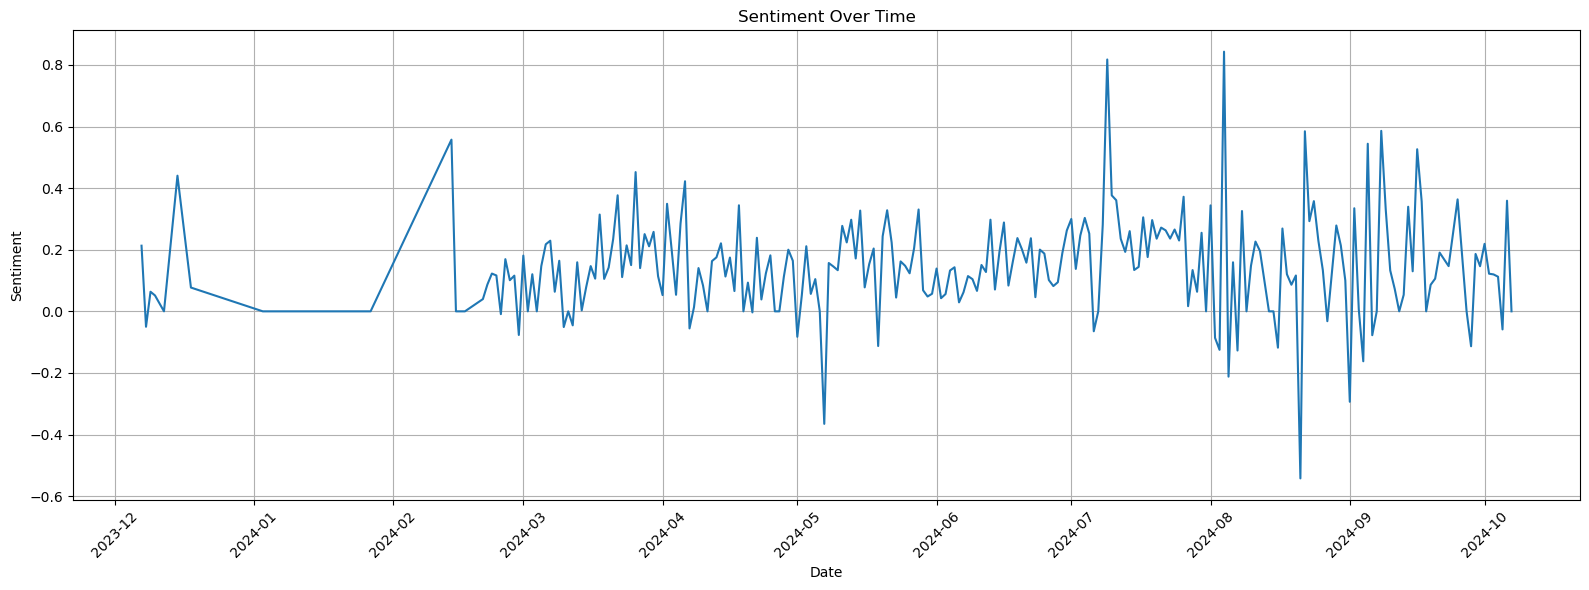

In [190]:
# sentiment for topic 5

topic_sentiments(topic5_words,start_date,end_date)

In [191]:
start_date = {'year': 2024, 'month': 6, 'day': 1}
end_date = {'year': 2024, 'month': 6, 'day': 30}

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/69169 [00:00<?, ?it/s]

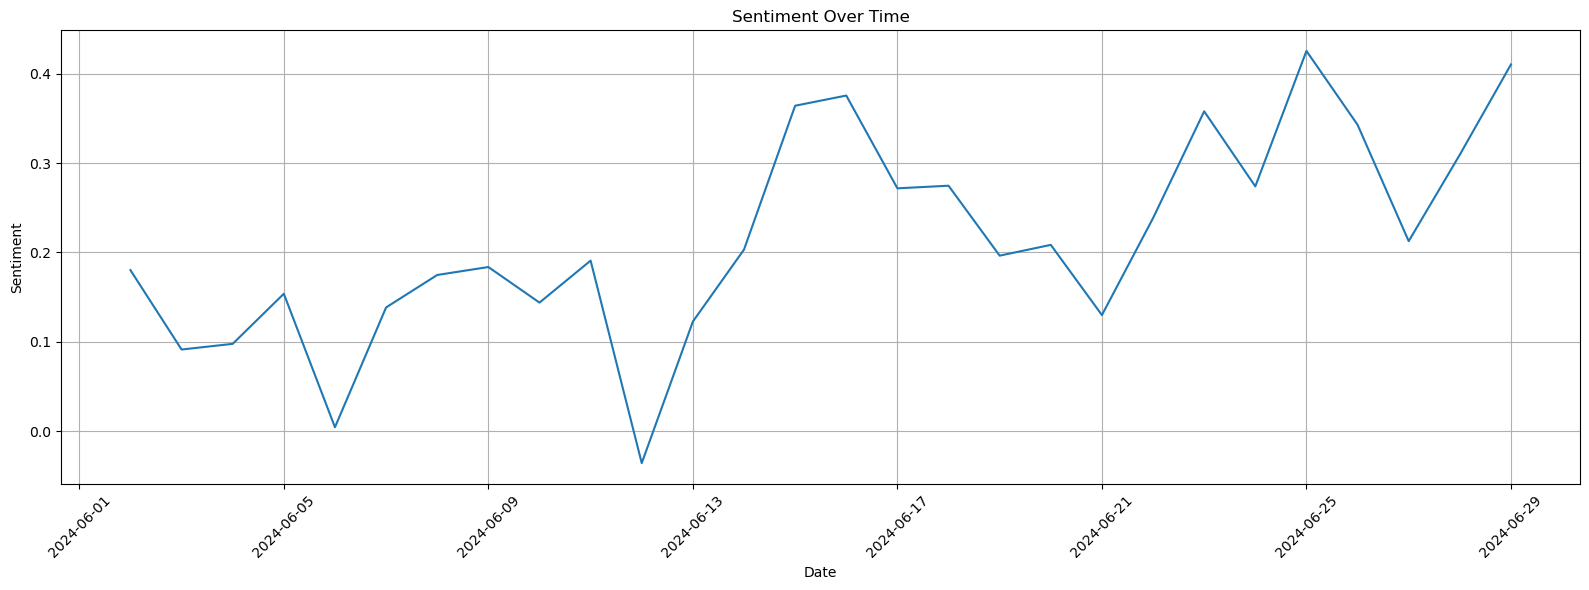

In [192]:
# sentiment for topic 2

topic_sentiments(topic2_words,start_date,end_date)